**Name:** WANG Enrui

**EID:** enruiwang2

# CS4487 - Tutorial 8: Non-Linear Dimensionality Reduction and Face Recognition

In this tutorial, you will apply non-linear dimensionality reduction on face images and train a classifier for face recognition. 

First we need to initialize Python. Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
import joblib
from numpy import *
from sklearn import *
import glob
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
random.seed(4487)
rbow = plt.get_cmap('rainbow')

/var/folders/g5/h7xzp71j4ybgtk0ysvslv8fc0000gq/T/ipykernel_57569/3248494498.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.core.display.set_matplotlib_formats("svg")


## Loading Data and Pre-processing
Run the following cell to load the images.

In [2]:
oli = datasets.fetch_olivetti_faces(data_home="./")
X = oli.data
Y = oli.target
img = oli.images
imgsize = oli.images[0].shape

Each image is a 64x64 array with pixel values, which can be flattened to a 4096-dimensional vector.  Run the below code to show all the images!

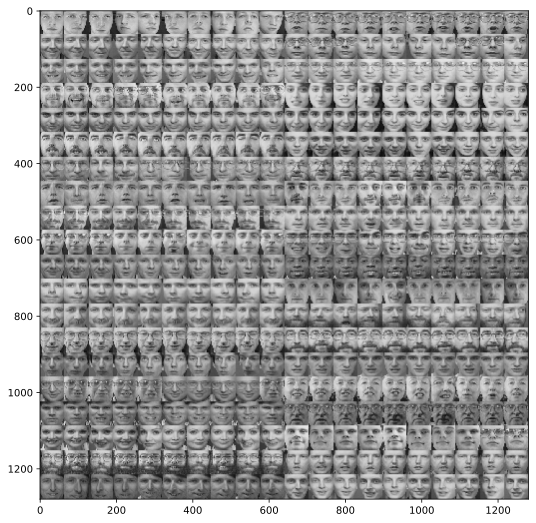

In [3]:
tmp = []
for i in range(0,400,20):
    tmp.append( hstack(img[i:i+20]) )
allimg = vstack(tmp)
plt.figure(figsize=(9,9))
plt.imshow(allimg, cmap='gray', interpolation='nearest')
plt.show()

Each person is considered as one class, and there are 10 images for each class.  In total, there are 40 classes (people).  The data are already vectorized and put into the matrix `X`. Now we split the data into training set and test set.

In [4]:
# randomly split the data (80% for training and 20% for test)
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)

(320, 4096)
(80, 4096)


## Non-Linear Dimensionality Reduction - KPCA
The dimension of the data is too large (4096) so training a classifier will take a long time. Our strategy is to use KPCA to reduce the data dimension first. Then, we use the KPCA weights as the representation for each image. 

Run KPCA on the data using **10** principal components. Use the RBF kernel with gamma=0.001.

In [5]:
### INSERT YOUR CODE HERE
## HINT
# 1. decomposition.KernelPCA(n_components= , kernel= , gamma= , n_jobs= )
kpca=decomposition.KernelPCA(n_components=10 , kernel="rbf" , gamma=0.001 , n_jobs=-1)
kpca.fit(trainX)

KernelPCA(gamma=0.001, kernel='rbf', n_components=10, n_jobs=-1)

The below function will plot the basis vectors of KPCA. Run the next 2 cells to view the PCs. The kernel PCs are a combination of similarities among data points in the training set. The PCs are visualized by showing the top 5 positive and negative training examples, along with their coefficient $\alpha_i$.

In [6]:
def plot_kbasis(model, imgsize, X):
    KK = model.n_components
    alphas = model.alphas_.T
    minmax = 5
    
    py = KK
    px = minmax*2
    for i in range(KK):
        # sort alphas
        inds = argsort(alphas[i,:])

        myi = r_[arange(-1,-minmax-1,-1), arange(minmax-1,-1,-1)]
        myinds = inds[myi]
        
        for j,jj in enumerate(myinds):
            plt.subplot(py,px,(j+1)+i*px)
            plt.imshow(X[jj,:].reshape(imgsize), interpolation='nearest')
            plt.gray()
            if alphas[i,jj]<0:
                mycol = 'b'
            else:
                mycol = 'r'
            plt.title("{:.3f}".format(alphas[i,jj]), fontsize=7, color=mycol)
            if (j==0):
                plt.ylabel('PC' + str(i+1))
            plt.xticks([])
            plt.yticks([])

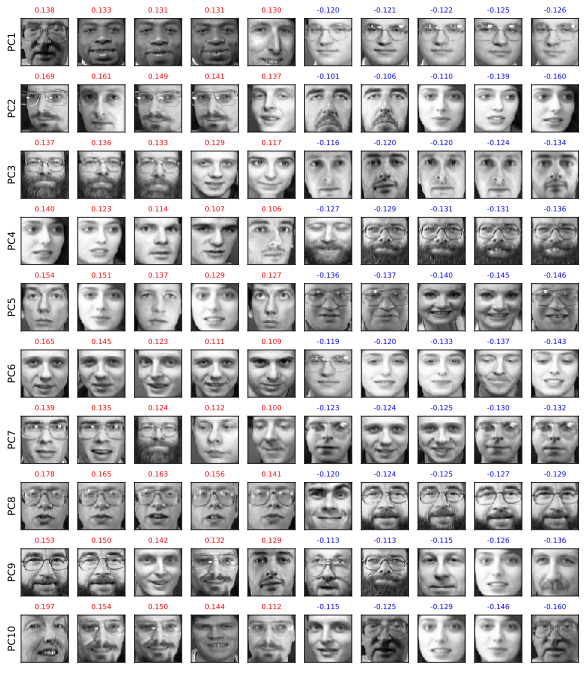

In [7]:
# run the function
plt.figure(figsize=(10,12))
plot_kbasis(kpca, imgsize, trainX)

_What is the interpretation for the KPCA basis?  What kind of faces do some of the PCs prefer?_
- **INSERT YOUR ANSWER HERE**

Kernel principal component analysis (kernel PCA) is an extension of principal component analysis (PCA) using techniques of kernel methods. Using a kernel, the originally linear operations of PCA are performed in a reproducing kernel Hilbert space.
Some of the PCs prefer the faces with more features.

### Face Recognition
Now train a logistic classifier to do the face recognition.  Use the calculated KPCA representation as the new set of inputs.  Use cross-validation to set the hyperparameters of the classifier.  You do not need to do cross-validation for the number of components or kernel hyperparameters.  Calculate the average training and testing accuracies.  Remember to transform the test data into the KPCA representation too!


In [8]:
### INSERT YOUR CODE HERE
## HINT 
# 1. linear_model.LogisticRegressionCV(Cs= , cv= , n_jobs= )
# 2. acc = metrics.accuracy_score( , )
trainX_kpca = kpca.transform(trainX)
testX_kpca = kpca.transform(testX)
logreg=linear_model.LogisticRegressionCV(Cs=logspace(-3,3,20), cv=3, n_jobs=-1,max_iter=10000)
logreg.fit(trainX_kpca,trainY)

predYtrain=logreg.predict(trainX_kpca)
train_score=metrics.accuracy_score(trainY, predYtrain)
print(train_score)


predYtest=logreg.predict(testX_kpca)
test_score=metrics.accuracy_score(testY, predYtest)
print(test_score)

0.984375
0.825


## Non-Linear Dimensionality Reduction - ICA

Next, we will use ICA to reduce the dimension.

- Applying the ICA with **20** principal components as the representation for each image. 
- Using the calculated ICA representation to  train a logistic classifier to do the face recognitio. 
- Calculating the average training and testing accuracies. 

In [9]:
### INSERT YOUR CODE HERE
## HINT
# 1. decomposition.FastICA(n_components=  )
# 2. linear_model.LogisticRegressionCV(Cs= , cv= , n_jobs= )
ica=decomposition.FastICA(n_components=20)
ica.fit(trainX)

trainX_ica = ica.transform(trainX)
testX_ica = ica.transform(testX)
logreg=linear_model.LogisticRegressionCV(Cs=logspace(-3,3,20), cv=3, n_jobs=-1,max_iter=10000)
logreg.fit(trainX_ica,trainY)

predYtrain=logreg.predict(trainX_ica)
train_score=metrics.accuracy_score(trainY, predYtrain)
print(train_score)


predYtest=logreg.predict(testX_ica)
test_score=metrics.accuracy_score(testY, predYtest)
print(test_score)

1.0
0.925


## Finding the best kernel and best number of components
Now try different kernels (poly and RBF), kernel parameters, and number of components to get the best test accuracy using KPCA.  Train a logistic classifier for each one and see which dimension gives the best test accuracy.

In [10]:
### INSERT YOUR CODE HERE
## HINT
#1. gammas = [0.0001, 0.0005, 0.001, 0.005, 0.01] (kernel parameters for RBF kernel)
#2. degrees = [1,2,3,4,5] (Degree for poly kernel)
#2. ncs = [5, 10, 15, 20, 25, 30] (number of components)
gammas = [0.0001, 0.0005, 0.001, 0.005, 0.01]
degrees = [1,2,3,4,5]
ncs = [5, 10, 15, 20, 25, 30]


trainacc=[]
trainacc_poly=[]
testacc=[]
testacc_poly=[]
for gamma in gammas:
    trainscore=[]
    testscore=[]
    for nc in ncs:
        kpca=decomposition.KernelPCA(n_components=nc , kernel="rbf" , gamma=gamma , n_jobs=-1)
        kpca.fit(trainX)
        trainX_kpca = kpca.transform(trainX)
        testX_kpca = kpca.transform(testX)
        logreg=linear_model.LogisticRegressionCV(Cs=logspace(-3,3,20), cv=3, n_jobs=-1,max_iter=10000)
        logreg.fit(trainX_kpca,trainY)

        predYtrain=logreg.predict(trainX_kpca)
        train_score=metrics.accuracy_score(trainY, predYtrain)
        trainscore.append(train_score)
    
        predYtest=logreg.predict(testX_kpca)
        test_score=metrics.accuracy_score(testY, predYtest)
        testscore.append(test_score)
    trainacc.append(trainscore)
    testacc.append(testscore)

        
for degree in degrees:
    trainscore=[]
    testscore=[]
    for nc in ncs:
        kpca=decomposition.KernelPCA(n_components=nc , kernel="poly" , degree=degree , n_jobs=-1)
        kpca.fit(trainX)
        trainX_kpca = kpca.transform(trainX)
        testX_kpca = kpca.transform(testX)
        logreg=linear_model.LogisticRegressionCV(Cs=logspace(-3,3,20), cv=3, n_jobs=-1,max_iter=10000)
        logreg.fit(trainX_kpca,trainY)

        predYtrain=logreg.predict(trainX_kpca)
        train_score=metrics.accuracy_score(trainY, predYtrain)
        trainscore.append(train_score)
    
        predYtest=logreg.predict(testX_kpca)
        test_score=metrics.accuracy_score(testY, predYtest)
        testscore.append(test_score)
    trainacc_poly.append(trainscore)
    testacc_poly.append(testscore)
                         

In [11]:
trainacc=array(trainacc)
testacc=array(testacc)

trainacc_poly=array(trainacc_poly)
testacc_poly=array(testacc_poly)
print(trainacc)
print(testacc)
print(trainacc_poly)
print(testacc_poly)

[[0.69375  0.940625 0.9875   1.       0.996875 1.      ]
 [0.79375  0.978125 1.       1.       1.       1.      ]
 [0.828125 0.984375 1.       1.       1.       1.      ]
 [0.765625 0.971875 1.       1.       1.       1.      ]
 [0.76875  0.996875 1.       1.       1.       1.      ]]
[[0.55   0.7125 0.8625 0.9125 0.925  0.925 ]
 [0.5625 0.8375 0.9    0.925  0.95   0.9375]
 [0.55   0.825  0.9    0.9375 0.95   0.95  ]
 [0.525  0.7875 0.9125 0.9    0.925  0.925 ]
 [0.625  0.8375 0.9    0.9    0.8875 0.925 ]]
[[0.715625 0.94375  1.       1.       1.       1.      ]
 [0.771875 0.975    1.       1.       1.       1.      ]
 [0.8      0.9875   1.       1.       1.       1.      ]
 [0.809375 0.99375  1.       1.       1.       1.      ]
 [0.809375 0.996875 1.       1.       1.       1.      ]]
[[0.5375 0.75   0.8625 0.9125 0.9375 0.9375]
 [0.55   0.775  0.9    0.9125 0.9375 0.9375]
 [0.5625 0.7875 0.9    0.925  0.9375 0.9625]
 [0.5625 0.8375 0.9    0.925  0.9375 0.95  ]
 [0.55   0.85   0.9   

 Plot the number of components vs. test accuracy.

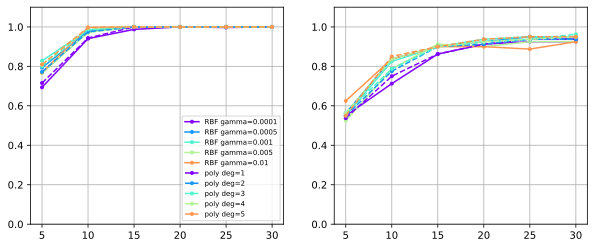

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for i,gamma in enumerate(gammas):
    plt.plot(ncs, trainacc[i,:], '.-', color=rbow(float(i)/len(gammas)), label="RBF gamma="+str(gamma))
for i,d in enumerate(degrees):
    plt.plot(ncs, trainacc_poly[i,:], '.--', color=rbow(float(i)/len(degrees)), label="poly deg="+str(d))
plt.ylim(0,1.1)    

plt.legend(loc="lower right", fontsize=7)
plt.grid(True)
plt.subplot(1,2,2)
for i,gamma in enumerate(gammas):
    plt.plot(ncs, testacc[i,:], '.-', color=rbow(float(i)/len(gammas)))
for i,d in enumerate(degrees):
    plt.plot(ncs, testacc_poly[i,:], '.--', color=rbow(float(i)/len(degrees)))
plt.ylim(0,1.1)    
    
plt.grid(True)

_What is the best kernel and number of components?_
- **INSERT YOUR ANSWER HERE**
Poly.
30

  View the prototypes for each compenent to see what the model (RBF kernel) with best kernel and number of components looks like.

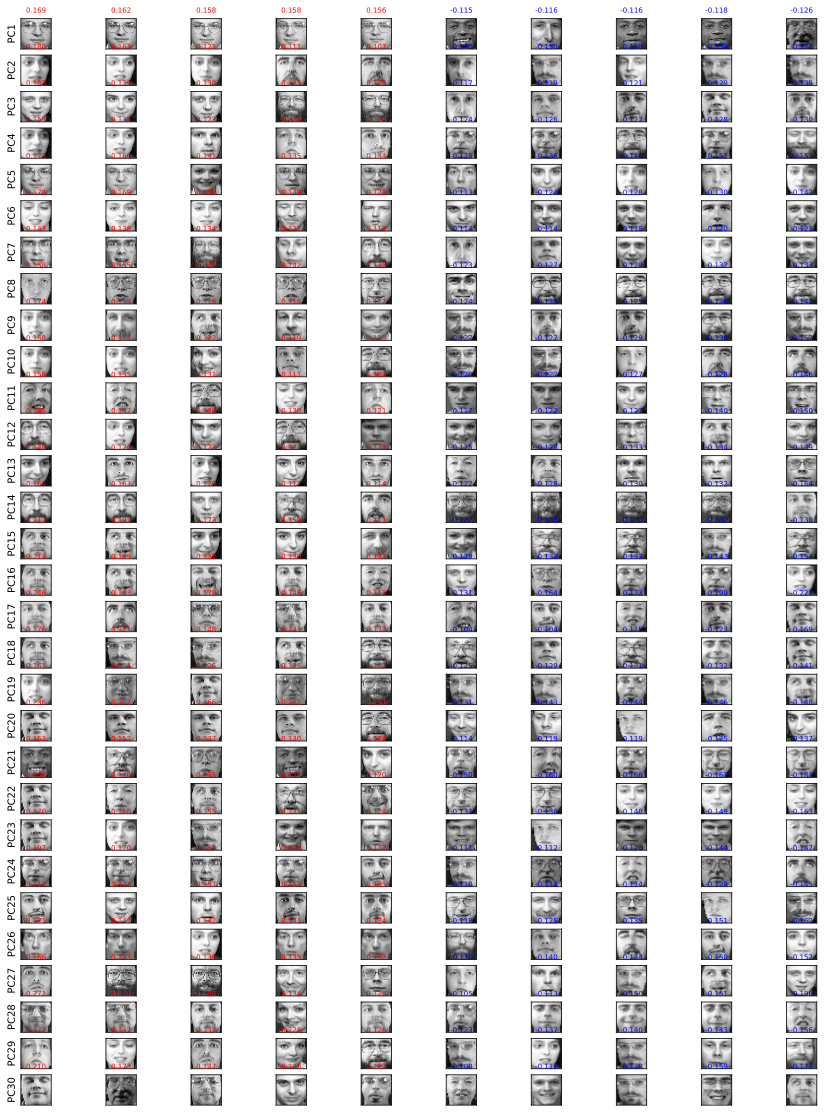

In [13]:
### INSERT YOUR CODE HERE
## HINT
# 1. ii = unravel_index(argmax(testacc), testacc.shape)
# 2. gamma = gammas[ii[0]]
# 3. plot_kbasis(kpca, imgsize, trainX)

ii = unravel_index(argmax(testacc), testacc.shape)
gamma = gammas[ii[0]]
plt.figure(figsize=(15,20))
plot_kbasis(kpca, imgsize, trainX)